### NAME: Anushka Chaubey
### Course: Engineering Analytics
### Assignment 03

In [4]:
# !pip install pyDOE torchdiffeq

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=a16d966d1b3862caf0620fddadf17f8ee6ad0803698989a0789720b7e89b4e4a
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


# Question 1
1. In this assignment, you will use Physics-Informed Neural Networks (PINNs) to estimate cardiac activation times on a 2D domain using sparse data. You will compare the PINN approach with a purely
data-driven neural network and linear interpolation.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from pyDOE import lhs

## PART A

In [5]:
# ---- Part A: Data Generation ----
def true_T(x, y):
    return np.minimum(np.sqrt(x**2 + y**2), 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2))

def V(x, y):
    cond = np.sqrt(x**2 + y**2) < 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.where(cond, 1.0, 1/0.7)

# Generate 30 samples via LHS
N = 30
lhs_samples = lhs(2, samples=N)
X = 2 * lhs_samples  # scale to [0, 2]
y = true_T(X[:, 0], X[:, 1])

## PART B

In [8]:
# ---- Part B: Model Definition and Training ----
class FeedforwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Prepare data
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

model = FeedforwardNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.2573
Epoch 10, Loss: 0.0511
Epoch 20, Loss: 0.0466
Epoch 30, Loss: 0.0304
Epoch 40, Loss: 0.0228
Epoch 50, Loss: 0.0178
Epoch 60, Loss: 0.0146
Epoch 70, Loss: 0.0121
Epoch 80, Loss: 0.0102
Epoch 90, Loss: 0.0086
Epoch 100, Loss: 0.0072
Epoch 110, Loss: 0.0060
Epoch 120, Loss: 0.0049
Epoch 130, Loss: 0.0039
Epoch 140, Loss: 0.0030
Epoch 150, Loss: 0.0024
Epoch 160, Loss: 0.0019
Epoch 170, Loss: 0.0015
Epoch 180, Loss: 0.0012
Epoch 190, Loss: 0.0009


In [15]:
import torch.nn.functional as F

def V_tensor(xy):
    x, y = xy[:, 0], xy[:, 1]
    cond = torch.sqrt(x**2 + y**2) < 0.7 * torch.sqrt((x - 1)**2 + (y - 1)**2)
    return torch.where(cond, torch.tensor(1.0), torch.tensor(1/0.7)).unsqueeze(1)

def compute_eikonal_loss(model, X):
    X = X.clone().detach().requires_grad_()  # Safe way to enable grad tracking
    T_pred = model(X)

    grad = torch.autograd.grad(
        outputs=T_pred,
        inputs=X,
        grad_outputs=torch.ones_like(T_pred),
        create_graph=True,
        retain_graph=True
    )[0]  # Gradient ∇T: shape (N, 2)

    grad_norm = torch.norm(grad, dim=1, keepdim=True)  # ||∇T||
    V_val = V_tensor(X)
    residual = V_val * grad_norm - 1
    return torch.mean(residual ** 2)

### Training Model 2
model2 = FeedforwardNN()
optimizer2 = optim.Adam(model2.parameters(), lr=5e-3) #5e-5
for epoch in range(1000):
    optimizer2.zero_grad()
    loss = compute_eikonal_loss(model2, X_tensor.clone())
    loss.backward()
    optimizer2.step()
    if epoch % 100 == 0:
        print(f"[Model 2] Epoch {epoch}, Eikonal Loss: {loss.item():.4f}")


[Model 2] Epoch 0, Eikonal Loss: 0.9399
[Model 2] Epoch 100, Eikonal Loss: 0.0012
[Model 2] Epoch 200, Eikonal Loss: 0.0003
[Model 2] Epoch 300, Eikonal Loss: 0.0002
[Model 2] Epoch 400, Eikonal Loss: 0.0002
[Model 2] Epoch 500, Eikonal Loss: 0.0001
[Model 2] Epoch 600, Eikonal Loss: 0.0005
[Model 2] Epoch 700, Eikonal Loss: 0.0002
[Model 2] Epoch 800, Eikonal Loss: 0.0000
[Model 2] Epoch 900, Eikonal Loss: 0.0000


## PART C

Model 1 RMSE: 0.0262
Model 2 RMSE: 1.0339


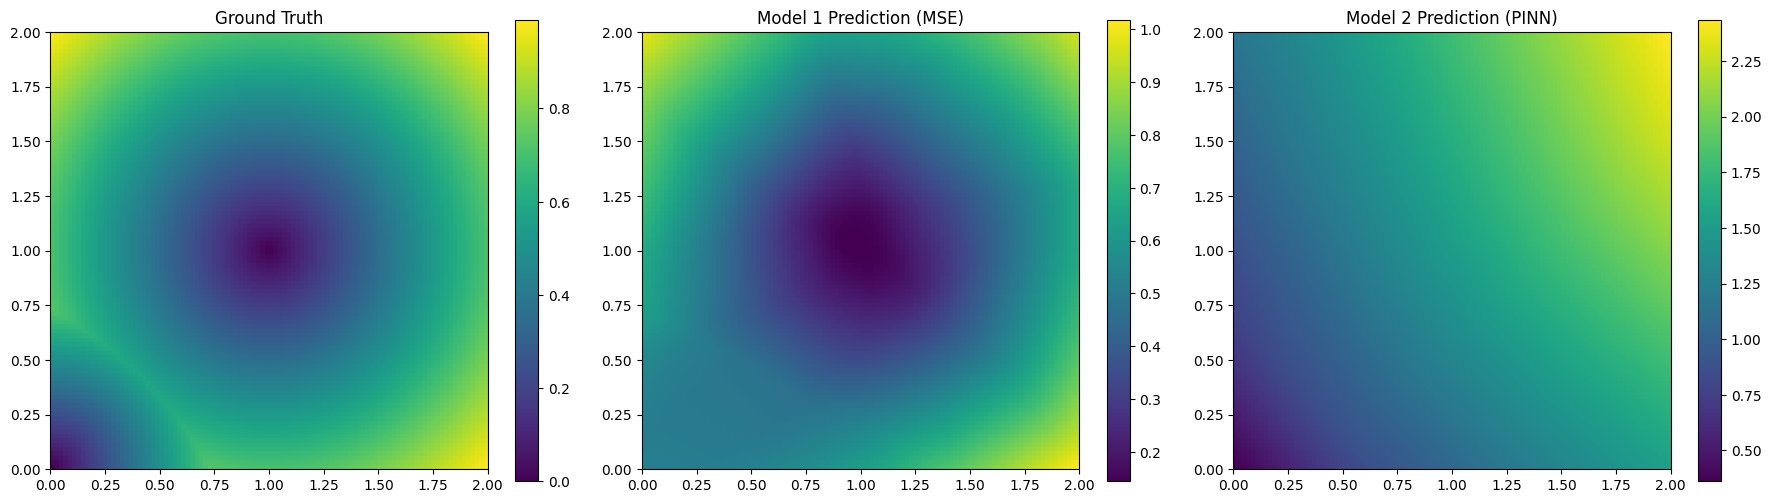

In [16]:
import matplotlib.pyplot as plt

# Dense test grid
xv, yv = np.meshgrid(np.linspace(0, 2, 100), np.linspace(0, 2, 100))
grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Predictions
with torch.no_grad():
    T_true = true_T(grid_points[:, 0], grid_points[:, 1])
    T_pred1 = model(X_tensor).detach().numpy().flatten()
    T_pred2 = model2(grid_tensor).detach().numpy().flatten()

    RMSE1 = np.sqrt(np.mean((T_pred1 - y.flatten())**2))
    RMSE2 = np.sqrt(np.mean((T_pred2 - T_true)**2))

    print(f"Model 1 RMSE: {RMSE1:.4f}")
    print(f"Model 2 RMSE: {RMSE2:.4f}")

# Reshape for plotting
T_true_grid = T_true.reshape(100, 100)
T_pred1_grid = model(grid_tensor).detach().numpy().reshape(100, 100)
T_pred2_grid = model2(grid_tensor).detach().numpy().reshape(100, 100)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Ground Truth', 'Model 1 Prediction (MSE)', 'Model 2 Prediction (PINN)']
datas = [T_true_grid, T_pred1_grid, T_pred2_grid]

for ax, title, data in zip(axes, titles, datas):
    im = ax.imshow(data, extent=[0,2,0,2], origin='lower', cmap='viridis')
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


# Hybrid Physics Loss: Improved PINNS

In [73]:
def hybrid_loss(model, X, y_true, alpha=1.0, beta=1.0):
    # MSE Loss (data loss)
    T_pred = model(X)
    loss_data = F.mse_loss(T_pred, y_true)

    # Eikonal Residual Loss
    X_phys = X.clone().detach().requires_grad_()  # ✅ create new tensor with grad tracking
    T_pred_res = model(X_phys)

    grad = torch.autograd.grad(
        outputs=T_pred_res,
        inputs=X_phys,
        grad_outputs=torch.ones_like(T_pred_res),
        create_graph=True,
        retain_graph=True
    )[0]

    grad_norm = torch.norm(grad + 1e-12, dim=1, keepdim=True)
    V_val = V_tensor(X_phys)
    residual = V_val * grad_norm - 1
    loss_phys = torch.mean(residual ** 2)

    return alpha * loss_data + beta * loss_phys


### Training Model 3
def training(lr,alpha,beta):
    model3 = FeedforwardNN()
    optimizer3 = optim.Adam(model3.parameters(), lr=lr) #1e-3
    for epoch in range(1000):
        optimizer3.zero_grad()
        # loss = compute_eikonal_loss(model3, X_tensor.clone())
        loss = hybrid_loss(model3, X_tensor.clone(), y_tensor,alpha,beta)
        loss.backward()
        optimizer3.step()
    print(f"lr: {lr} | a:b  {alpha}:{beta}")
        # if epoch % 100 == 0:
        #     print(f"[Model 2] Epoch {epoch}, Eikonal Loss: {loss.item():.4f}")
    return model3




import matplotlib.pyplot as plt

def evalM(model,model2,model3):
    # Dense test grid
    xv, yv = np.meshgrid(np.linspace(0, 2, 100), np.linspace(0, 2, 100))
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Predictions
    with torch.no_grad():
        T_true = true_T(grid_points[:, 0], grid_points[:, 1])
        T_pred1 = model(X_tensor).detach().numpy().flatten()
        T_pred2 = model2(grid_tensor).detach().numpy().flatten()
        T_pred3 = model3(grid_tensor).detach().numpy().flatten()
        
    
        RMSE1 = np.sqrt(np.mean((T_pred1 - y.flatten())**2))
        RMSE2 = np.sqrt(np.mean((T_pred2 - T_true)**2))
        RMSE3 = np.sqrt(np.mean((T_pred3 - T_true)**2))
        
        if RMSE3<0.1:
            print(f"Model 1(NN) RMSE: {RMSE1:.4f}")
            print(f"Model 2(phy) RMSE: {RMSE2:.4f}")
            print(f"Model 2(hybrid loss) RMSE: {RMSE3:.4f}")
        else:
            model3=training(lr=0.005,alpha=1,beta=10)
            evalM(model,model2,model3)
        
    
    # Reshape for plotting
    T_true_grid = T_true.reshape(100, 100)
    T_pred1_grid = model(grid_tensor).detach().numpy().reshape(100, 100)
    T_pred2_grid = model2(grid_tensor).detach().numpy().reshape(100, 100)
    T_pred3_grid = model3(grid_tensor).detach().numpy().reshape(100, 100)
    
    
# Plot in 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns
    axes = axes.flatten()  # Flatten 2D array to 1D for easy iteration
    
    titles = ['Ground Truth', 'Model 1 Prediction (MSE)', 'Model 2 PINN', 'Model 3 Hybrid Loss (PINN)']
    datas = [T_true_grid, T_pred1_grid, T_pred2_grid, T_pred3_grid]
    
    for ax, title, data in zip(axes, titles, datas):
        im = ax.imshow(data, extent=[0, 2, 0, 2], origin='lower', cmap='viridis')
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()


lr: 0.005 | a:b  1:10
Model 1(NN) RMSE: 0.0262
Model 2(phy) RMSE: 1.0339
Model 2(hybrid loss) RMSE: 0.0792


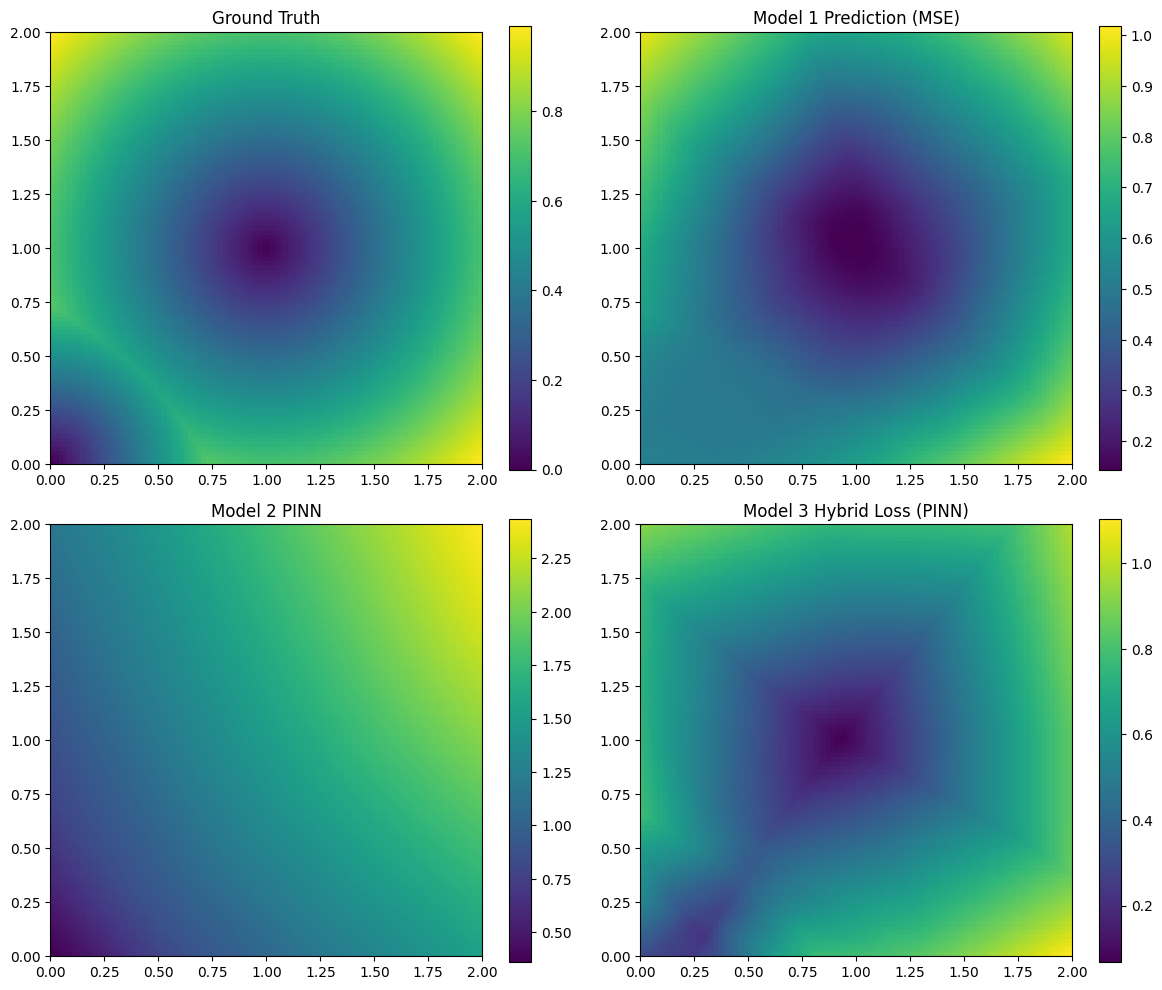

In [82]:
model3=training(lr=0.005,alpha=1,beta=10)
evalM(model,model2,model3)

# Question 2

2. This assignment introduces Neural Ordinary Differential Equations (Neural ODEs) as a continuous alternative to standard neural network layers. You will compare a standard 1-hidden-layer neural network
with a Neural ODE model for a simple classification task.

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchdiffeq import odeint


## Dataset 1

In [133]:
# Generate 2D moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale features to zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)


## Dataset 2

In [135]:

# 1. Prepare dataset (make_circles)
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## PART A, B

Training SimpleNN...

Training NeuralODE...
----------------------------------------
SimpleNN Final Train Accuracy: 0.9962
SimpleNN Final Test Accuracy: 0.9650
NeuralODE Final Train Accuracy: 1.0000
NeuralODE Final Test Accuracy: 0.9800


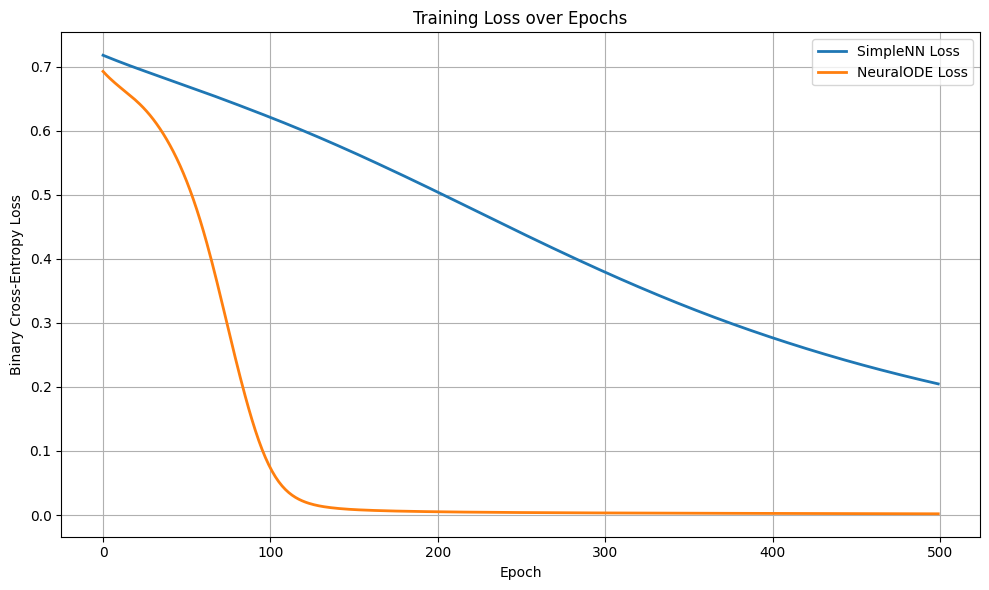

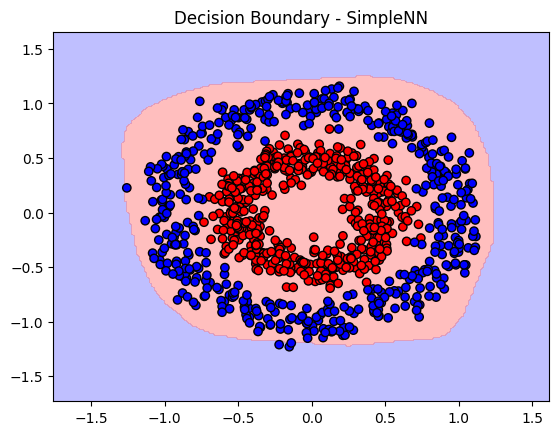

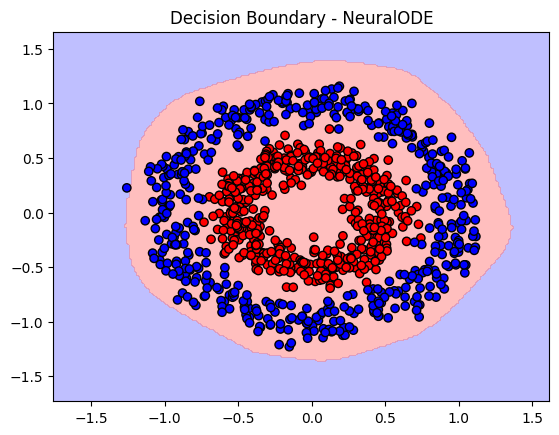

In [136]:

# Neural ODE package
# 2. Define standard 1-hidden-layer NN
class SimpleNN(nn.Module):
    def __init__(self, hidden_dim=32):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


# 3. Define Neural ODE block
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=32):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_dim),
        )

        # Initialize weights close to zero to stabilize training
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, h):
        return self.net(h)


# 4. Define Neural ODE model using odeint
class NeuralODE(nn.Module):
    def __init__(self, hidden_dim=32):
        super(NeuralODE, self).__init__()
        self.fc_in = nn.Linear(2, hidden_dim)
        self.odefunc = ODEFunc(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = self.fc_in(x)
        t = torch.tensor([0., 1.]).to(x)  # evolve from t=0 to t=1

        h_t = odeint(self.odefunc, h0, t, method='rk4')  # [time_steps, batch, features]
        h_final = h_t[-1]  # take output at t=1

        out = torch.sigmoid(self.fc_out(h_final))
        return out

# 5. Training function (same as before)
def train(model, X_train, y_train, X_test, y_test, epochs=500, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                train_acc = ((y_pred > 0.5) == y_train).float().mean().item()
                y_test_pred = model(X_test)
                test_acc = ((y_test_pred > 0.5) == y_test).float().mean().item()
            # print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model, loss_history



# After training print final accuracies
def print_final_accuracy(model, X_train, y_train, X_test, y_test, model_name):
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train)
        train_acc = ((train_preds > 0.5) == y_train).float().mean().item()
        test_preds = model(X_test)
        test_acc = ((test_preds > 0.5) == y_test).float().mean().item()
    print(f"{model_name} Final Train Accuracy: {train_acc:.4f}")
    print(f"{model_name} Final Test Accuracy: {test_acc:.4f}")



# 6. Plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor).numpy().reshape(xx.shape)
    plt.contourf(xx, yy, preds > 0.5, alpha=0.5, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title(title)
    plt.show()


# 7. Run experiments
print("Training SimpleNN...")
simple_nn = SimpleNN()
simple_nn, simple_loss = train(simple_nn, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

print("\nTraining NeuralODE...")
neural_ode = NeuralODE()
neural_ode, ode_loss = train(neural_ode, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

print('-'*40)
print_final_accuracy(simple_nn, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, "SimpleNN")
print_final_accuracy(neural_ode, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, "NeuralODE")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(simple_loss, label='SimpleNN Loss', linewidth=2)
plt.plot(ode_loss, label='NeuralODE Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot decision boundaries
plot_decision_boundary(simple_nn, X, y, "Decision Boundary - SimpleNN")
plot_decision_boundary(neural_ode, X, y, "Decision Boundary - NeuralODE")



## PART C

1. ODE Model Performs Much Better
The ODE model loss drops from very steep, to extremely low — indicating very high accuracy or overfitting.

The rapid decline implies strong representational power or highly flexible fitting capacity (typical of neural ODEs or dynamics-based models).

2. Simple NN is Slower and Less Accurate
It decreases smoothly drops over the same number of epochs.

This is a standard sigmoid-shaped loss curve without sharp turns — typical for basic fully connected networks with moderate capacity and learning rate.